In [3]:
#IPYNB For Optimizing KNN
#many of these libraries are probably not needed
import pandas as pd 
import numpy as np
import os
from skimage.feature import hog
import matplotlib.pyplot as plt
from KNN import knn_predict_L2
from plotutils import plot_data, plot_surface
from knncrossval import KNN_cross_validate
#from kernelsvm import SVM
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#cwd = os.getcwd() #if need the current directory 
df = pd.read_csv('digit-recognition/digit-recognition/train.csv')
df2 = pd.read_csv('digit-recognition/digit-recognition/test.csv')
#the shape of the dataframe is (38000, 785) meaning there are 38000 samples and 1 label with 784 features

In [5]:
#turn the training dataframe into numpy array 
label_data_train = df.to_numpy()

#column vector for the labels (38000,)
label_train = label_data_train[:,0] 

#( 38000 x 784 matrix for the training data  )
data_train = label_data_train[:, 1:] 
print(label_train.shape)
print(data_train.shape)

#turn testing dataframe into numpy array 
label_data_test = df2.to_numpy()
label_test = label_data_test[:,0]
data_test = label_data_test[:,1:]


(38000,)
(38000, 784)


In [8]:
# Determine our dataset size for cross validation and training
num_labels = len(np.unique(label_train))
num_cv_splits = 50
num_train_splits = 25 #int(num_cv_splits/2)
# Initialize variables here for convenient use throughout
k_value = [3, 4, 5, 6, 7, 8]
num_folds = 4

CV Subset selection: 5


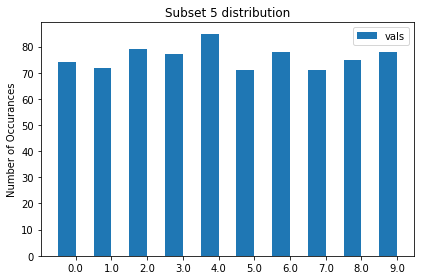

In [9]:
# We won't cross validation on the whole data set to save time. 
# Pick our subset by choosing the split with the most equal label distribution.

frequencies = np.zeros((num_cv_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_cv_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
cv_subset_selection = np.argmin(variances)
print("CV Subset selection: {0}".format(cv_subset_selection))

labels = frequencies[cv_subset_selection][:, 0]
vals = frequencies[cv_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(cv_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
split_cv_data = np.split(data_train, num_cv_splits)[cv_subset_selection]
split_cv_labels = np.split(label_train, num_cv_splits)[cv_subset_selection]

In [28]:
# Run cross validation on Minkowski KNN to determine optimal k-value 

best_score = 0
for j in range(len(k_value)):
    print(split_cv_data.shape)
    cv_score, _ = KNN_cross_validate(knn_predict_L2, split_cv_data, split_cv_labels, num_folds, k_value[j])
    if cv_score > best_score:
        best_score = cv_score
        best_k = k
print("Determined best parameters for Euclidean KNN: {0}".format(best_params))

(760, 784)


TypeError: 'numpy.float64' object is not iterable

In [22]:
print(data_train.shape)
print(data_test.shape)
#answers, count = knn_predict_L2(data_train, label_train, data_test[:500,:],best_k)

#print(answers.ravel().shape)

(38000, 784)
(4000, 784)


In [18]:
test_accuracy = np.mean(answers.ravel() == label_test[:500])
print(test_accuracy * 100)

97.6


In [ ]:
label_train[locations[:,:]]
print(label_train.shape)
print(label_train[locations[:,:]].shape)
print(label_train[locations[:,:]])

In [24]:
np.sum((data_train[0,:]-data_test[0,:])**2)
print(dist.shape)
optimal_locations = np.argsort(dist, axis=0)
k_matrix = optimal_locations[:3,:]
print(k_matrix.shape)
#this actually might be more inefficient
label_func = np.vectorize(label_train)
label_func(k_matrix)

(38000, 500)
(3, 500)


TypeError: 'numpy.ndarray' object is not callable

In [30]:

#unewighted KNN with euclidean distance for an instance 
#calculate using euclidean distance 
#would be data_test.shape[0]
knn_predicts = []
for i in range(500):
    knn_predicts.append(knn_predict_L2(data_train, label_train, data_test[i,:], 3))